# CSMODEL PHASE 1 - Froggers' Pokemon Analysis

In [3]:
# Imports and Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

## Chapter 1. Introduction

The nature of the data and the rationale behind its application will be discussed in this chapter. Information on how these data are gathered will also be addressed.

### 1.1 The Showdown Data set

The first dataset consists of records of a person's Pokemon battle. It specifically has columns of
* The battle's unique ID ("tag"), generated by Pokemon Showdown
* The name of the first player who participated in that battle (player 1)
* That player's elo ranking
* Which six Pokemon they used
* The lead Pokemon (which Pokemon they sent first)
* The turn count (how many turns the battle lasted)
* The result of that battle (win, lose, tie)

While a battle consists of two players each with their own unique features, we will delimit
our study to the scope of one person (player 1 only, and not player 2) and base our analyses from there.

This is because we mostly want to focus on identifying patterns on how a player builds their
teams given the meta irrespective of the other team. In Pokemon Showdown, teams are built
independently before players challenge each other and are not built "on the fly".

The specific data set we chose is matches done in the Generation 5 "Overused" format (Gen5OU). The reason
for this is this is the earliest version where the Pokemon Showdown implemented the feature where
you are able to see all of the opposing Pokemon from your opponent. This is important as it
enabled us to read the team composition of these matches.

#### 1.1.1 Scraping battle logs

Scraping the battle logs was done using a separate JavaScript program created by one of our
group members: [Showdown Scraper](https://github.com/jrgo7/showdown-scraper). Through this program, we were
able to **scrape the last 5000 recorded Gen5OU battles** from the Pokemon Showdown replay catalogue, which is all that
was available for this format. Unfortunately, this brings in a recency bias as we do not have access to the entire
population of Gen5OU Pokemon battles.

#### 1.1.2 Structuring battle logs

The battle logs by themselves are unstructured and are like chat messages in the sense that they are composed of lines
of "messages" that convey some information or action taken. A few examples:

```
|turn|1
```

represents the beginning of turn 1;

```
|poke|p1|Tyranitar, F|item
|poke|p1|Victini|item
|poke|p1|Excadrill, M|item
|poke|p1|Rotom-Wash|item
|poke|p1|Ferrothorn, F|item
|poke|p1|Latios, M|item
```

represents a definition of a set of 6 Pokemon for player 1 (the feature mentioned in section 1.1 which made us choose
this format in particular); and

```
|switch|p1a: Rotom|Rotom-Wash|100/100
```

represents that player 1 switched in ("sent out") the Pokemon named Rotom, who is currently at full HP (100/100).

These lines were parsed and processed into the [`showdown.csv`](./dataset/showdown/showdown.csv) file via the [`battlelogs_to_csv.py`](battlelogs_to_csv.py) script, containing the features mentioned in section 1.1.

In [4]:
showdown_df = pd.read_csv("./dataset/showdown/showdown.csv")
showdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tag          5000 non-null   int64 
 1   Player       5000 non-null   object
 2   Elo          5000 non-null   int64 
 3   Pokemon 1    5000 non-null   object
 4   Pokemon 2    5000 non-null   object
 5   Pokemon 3    5000 non-null   object
 6   Pokemon 4    5000 non-null   object
 7   Pokemon 5    5000 non-null   object
 8   Pokemon 6    5000 non-null   object
 9   LeadPokemon  4987 non-null   object
 10  TurnCount    5000 non-null   int64 
 11  Result       5000 non-null   object
dtypes: int64(3), object(9)
memory usage: 468.9+ KB


In [5]:
for column in ["Player", *[f"Pokemon {i}" for i in range(1,7)], "LeadPokemon", "Result"]:
    showdown_df[column] = showdown_df[column].astype("str")
    
showdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tag          5000 non-null   int64 
 1   Player       5000 non-null   object
 2   Elo          5000 non-null   int64 
 3   Pokemon 1    5000 non-null   object
 4   Pokemon 2    5000 non-null   object
 5   Pokemon 3    5000 non-null   object
 6   Pokemon 4    5000 non-null   object
 7   Pokemon 5    5000 non-null   object
 8   Pokemon 6    5000 non-null   object
 9   LeadPokemon  5000 non-null   object
 10  TurnCount    5000 non-null   int64 
 11  Result       5000 non-null   object
dtypes: int64(3), object(9)
memory usage: 468.9+ KB


#### 1.1.3 Ties

Matches do not always end in wins or losses; they can be ties, too.

In [6]:
showdown_df[showdown_df['Result'] == 'tie']

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
387,1083803355,professorcaralho,1390,Politoed,Latios,Rotom-Wash,Breloom,Jirachi,Scizor,Rotom-Wash,30,tie
796,113898835,professorcaralho,1390,Politoed,Latios,Rotom-Wash,Breloom,Jirachi,Scizor,Rotom-Wash,30,tie
4803,93999693,Volta,1329,Dragonite,Keldeo,Scizor,Terrakion,Latios,Garchomp,Terrakion,27,tie
4807,94150142,Volta,1329,Dragonite,Keldeo,Scizor,Terrakion,Latios,Garchomp,Terrakion,27,tie


#### 1.1.4 Forfeit matches

Some records report no `LeadPokemon`. These indicate that the match ended
prematurely, before the player sent out a Pokemon in the first place, likely due
to disconnection issues or one of the players forfeit the match.

Nevertheless, data from "battles" like these can still be used to identify
trends in team building from people of different elo levels.

(I'm sure there are instances where we'd have to drop these though, as we
previously mentioned)

In [7]:
showdown_df[showdown_df["TurnCount"] == 0]

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
69,101708749,WeForneMon,1660,Latios,Lucario,Gengar,Gastrodon,Heatran,Skarmory,nan,0,lose
377,1082937854,hgfjhds,1532,Tyranitar,Landorus-Therian,Rotom-Wash,Jirachi,Latios,Keldeo,nan,0,lose
798,1139401705,Wally,1653,Garchomp,Rotom-Wash,Tyranitar,Scizor,Latios,Terrakion,nan,0,win
811,1141004806,Wally,1653,Garchomp,Rotom-Wash,Tyranitar,Scizor,Latios,Terrakion,nan,0,win
1027,121892059,ALnlef,1307,Gliscor,Politoed,Rotom-Wash,Ferrothorn,Tentacruel,Tornadus,nan,0,lose
1307,2033253771,yusei38,1333,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,nan,0,win
1530,2058219606,yusei38,1333,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,nan,0,win
1667,2073047615,authentise_is_shit,1507,Politoed,Jellicent,Excadrill,Tornadus,Gastrodon,Ferrothorn,nan,0,lose
2283,2145224095,rabian,1345,Jolteon,Ferrothorn,Politoed,Gyarados,Toxicroak,Tentacruel,nan,0,lose
4052,588117142,Jack314,1314,Breloom,Garchomp,Latios,Jirachi,Rotom-Wash,Tyranitar,nan,0,lose


### 1.2 Generation 5 Base Stats

Species strengths, commonly referred to by fans as base stats (Japanese: 種族値 species values), are the inherent values of a species or form of a species that are used to the stats of a Pokémon (Bulbagarden). These statistics define a Pokemon's strength in that department, with 7 base stats affecting battle:\
- Health Points(HP) determines how much health a Pokemon has;
- Attack(ATK) determines how strong a Pokemon's physical moves are;
- Special Attack(SP ATK) determines how strong a Pokemon's special moves are;
- Defense(DEF) determines how resistant a Pokemon to physical moves are;
- Special Defense(SP DEF) determines how resistant a Pokemon to special moves are;
- Speed (SPD) determines how fast a Pokemon is, in context of a match will let a Pokemon move first on a turn.

This data set is used in addition to the Showdown matches to give some depth to the information with the inclusion of base stats since these greatly affect battle outcomes. This data set is gathered in the Bulbagarden website through this link: [Pokemon Generation II-V Stats)](https://m.bulbapedia.bulbagarden.net/wiki/List_of_Pokémon_by_base_stats_(Generation_II-V))

In [8]:
#Importing Generation 5 base stats data set
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
gen5_stats_df

,Pokedex number,Name,HP,Attack,Special Attack,Defense,Special Defense,Speed,Stat total,Stat average
0,1,Bulbasaur,45,49,49,65,65,45,318,53.00
1,2,Ivysaur,60,62,63,80,80,60,405,67.50
2,3,Venusaur,80,82,83,100,100,80,525,87.50
3,4,Charmander,39,52,43,60,50,65,309,51.50
4,5,Charmeleon,58,64,58,80,65,80,405,67.50
...,...,...,...,...,...,...,...,...,...,...
665,647,Keldeo,91,72,90,129,90,108,580,96.67
666,647,Keldeo-Resolute,91,72,90,129,90,108,580,96.67
667,648,Meloetta,100,77,77,128,128,90,600,100.00
668,648,Meloetta-Pirouette,100,128,90,77,77,128,600,100.00


In [9]:
gen5_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pokedex number   670 non-null    int64  
 1   Name             670 non-null    object 
 2   HP               670 non-null    int64  
 3   Attack           670 non-null    int64  
 4   Special Attack   670 non-null    int64  
 5   Defense          670 non-null    int64  
 6   Special Defense  670 non-null    int64  
 7   Speed            670 non-null    int64  
 8   Stat total       670 non-null    int64  
 9   Stat average     670 non-null    float64
dtypes: float64(1), int64(8), object(1)
memory usage: 52.5+ KB


### 1.3 Smogon Stats

Lastly, the Smogon statistics will be included. This data set details different summarized statistics regarding Pokemon beginning at November of 2014. These statistics are logged by the Poekmon Showdown site owners and are summarized monthly. Notable statistics regarding this would be the Pokemon's usage statistics, the build and moveset of the Pokemon and even descriptions regarding a match called the metagame such as pressence of weather effects and the stalliness of a game.

We specifically downloaded data on Gen5OU usage statistics in [2015](https://www.smogon.com/stats/2015-01/gen5ou-0.txt) and [2025](https://www.smogon.com/stats/2025-01/gen5ou-0.txt). The [`smogon-to-csv.py`](smogon-to-csv.py) script then parsed the text-based table format into a `.csv` file that we will be importing into a DataFrame later.

## Chapter 2. Research Questions and EDA's

### 2.1 Main Research Question

### 2.2 EDA's

#### 2.2.1 What is the distribution of base stats among teams, and are they Correlated?
Different Pokemon have different stats, and we would like to figure out what stats are correlated with one another to determine the relationships between different stats.

#### 2.2.2 Which Pokemon is generally more favored to go first other than the rest? What is their stat distribution?
The lead Pokemon of a team can set the pace of a match. Because of this, the choice of which Pokemon to send out is very important to a player. We would like to see which Pokemon is preferred by most people to send out first.

#### 2.2.3 Are battles done quicker by players with a higher skill level(ELO)?
More skilled players, assumed to be those who have a higher ELO in the rating system, likely understand the game better than beginners and can play more optimally. Knowing this, we would like to know if there is a correlation between the ELO of players and how fast they are able to finish the game.

#### 2.2.4 What are the types that are usually run on competitive Pokemon Teams?
Because of the typing mechanic of Pokemon, each with their specific strenghts and weaknesses, it is understandable if some types are preferred over others. We would like to know what these types are.

## Chapter 3. Data Pre-processing

#### This chapter focuses on the operations done to the data sets in order to tailor it for our analysis.

### 3.1 Data Cleaning

#### 3.1.1 Duplicate players

After formatting the columns, we have realized that while all the matches 
are different, multiple battles from the same players have been collected.

As we can see, some players prefer to use the exact same team composition
using the same Pokemon in different battles. This would lead to bias to
certain Pokemon and team compositions in general, as a player's reference
does not necessarily correlate with the actual meta determined by the community.

In order to not skew the data to the preferences/team-building of some players,
we have chosen to drop these duplicate players in order to get a better view of
the community.

In [10]:
team_cols = ["Player"] + [f"Pokemon {i}" for i in range(1, 7)]
showdown_df[showdown_df.duplicated(subset=team_cols, keep=False)].sort_values(by="Player")

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
4852,95498129,(LoD)Marcos,1444,Gengar,Volcarona,Salamence,Jirachi,Mienshao,Scrafty,Gengar,37,lose
4847,95190427,(LoD)Marcos,1392,Gengar,Volcarona,Salamence,Jirachi,Mienshao,Scrafty,Gengar,18,win
1717,2080451177,123perejil123,1325,Tyranitar,Landorus-Therian,Excadrill,Clefable,Latios,Slowbro,Latios,2,win
1647,2069514743,123perejil123,1325,Tyranitar,Landorus-Therian,Excadrill,Clefable,Latios,Slowbro,Latios,2,win
3288,2293763103,133fcsq,1464,Politoed,Keldeo,Latios,Starmie,Thundurus-Therian,Jirachi,Keldeo,25,win
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,171229752,yusei38,1268,Politoed,Skarmory,Espeon,Kyurem-Black,Blissey,Jolteon,Jolteon,21,win
3827,2363527686,zerqaq,1368,Landorus-Therian,Politoed,Starmie,Ferrothorn,Jirachi,Latios,Politoed,16,win
3826,2363486536,zerqaq,1347,Landorus-Therian,Politoed,Starmie,Ferrothorn,Jirachi,Latios,Landorus-Therian,28,win
71,101724423,Śhofũ,1434,Politoed,Chansey,Skarmory,Tentacruel,Celebi,Tangrowth,Chansey,148,win


In [11]:
showdown_df = showdown_df.drop_duplicates(subset="Player", keep="first")
showdown_df

,Tag,Player,Elo,Pokemon 1,Pokemon 2,Pokemon 3,Pokemon 4,Pokemon 5,Pokemon 6,LeadPokemon,TurnCount,Result
0,1000949555,HaxerShouldAllDie,1444,Infernape,Breloom,Tyranitar,Jellicent,Bronzong,Reuniclus,Infernape,24,lose
2,100157536,BigBadLeroyBrown,1306,Tyranitar,Alakazam,Latios,Ferrothorn,Landorus-Therian,Excadrill,Tyranitar,31,win
3,1001647389,testing4g4in,1488,Tyranitar,Amoonguss,Starmie,Alakazam,Heatran,Skarmory,Starmie,22,lose
4,100171063,bossaru2,1377,Tyranitar,Stoutland,Forretress,Salamence,Gliscor,Breloom,Breloom,24,lose
5,100192677,jo0n vo0ight,1312,Tornadus,Politoed,Tentacruel,Dugtrio,Ferrothorn,Jirachi,Tornadus,22,lose
...,...,...,...,...,...,...,...,...,...,...,...,...
4981,991306568,shiny peoples,1304,Politoed,Amoonguss,Excadrill,Thundurus-Therian,Keldeo,Ferrothorn,Politoed,22,lose
4983,99232112,My Nostalgic Past,1268,Politoed,Gyarados,Jolteon,Ferrothorn,Haxorus,Umbreon,Politoed,71,win
4987,99352898,Sneakypanda,1393,Scizor,Togekiss,Hippowdon,Infernape,Terrakion,Sableye,Infernape,25,lose
4988,993678093,Caster33,1287,Tyranitar,Garchomp,Heatran,Conkeldurr,Forretress,Jellicent,Garchomp,14,win


### 3.2 Feature Engineering

#### 3.2.1 Base Stats

In the data set, each team consists of 6 Pokémon, which makes it challenging to represent the individual statistics of every team member. To address this, the base stats of all Pokémon on a team are aggregated and represented as the average of the team's base stats, providing a more manageable and holistic view of team strength. Additionally, the base stat of the lead Pokémon—the one that starts the battle—is specifically logged in the data set, allowing for more detailed analysis of how the lead's attributes may influence team performance or battle outcomes. This approach ensures both team-wide and individual lead insights are captured for more comprehensive analysis.

In [12]:
stats = ['HP', 'Attack', 'Special Attack', 'Defense', 'Special Defense', 'Speed']

#Create Columns
for stat in stats:
    showdown_df[f'Avg_{stat}'] = 0.0

for row in showdown_df.itertuples():
    pkmn_name = showdown_df.at[row.Index, f"LeadPokemon"]
    #Checks for "nan" since column is stringified
    if (pkmn_name != "nan"):
        #Takes base stat from gen5_stats_df to Lead pokemon stats
        for stat in stats:
            leadStat = gen5_stats_df.loc[gen5_stats_df['Name'] == pkmn_name, stat].values[0]
            showdown_df.at[row.Index, f'Lead_{stat}'] = leadStat
    
    #Iterates over every pokemon in the team then every stat, for the average stat
    for i in range(1, 7):
        pkmn_name = showdown_df.at[row.Index, f"Pokemon {i}"]
        for stat in stats:
            stat_point = gen5_stats_df.loc[gen5_stats_df['Name'] == pkmn_name, stat].values[0]
            showdown_df.at[row.Index, f'Avg_{stat}'] += stat_point / 6

### 3.3 Finalized Showdown Data set

We save the showdown data frame as a new csv so as to not repeat the pre-processing done to the data set.

In [13]:
#Save data set to showdown.csv
showdown_df.to_csv('showdown.csv', index=False)

In [14]:
#Load saved showdown.csv
showdown_df = pd.read_csv("showdown.csv")

## Chapter 4. Exploratory Data Analysis

### 4.1 Base Stats

#### 4.1.1 Distribution of Average Base Stats in Pokemon Teams

Each team is made up of 6 different Pokemon with their own stats. Getting
the average stats of a team can show us what different people prioritize
in building their Pokemon team.

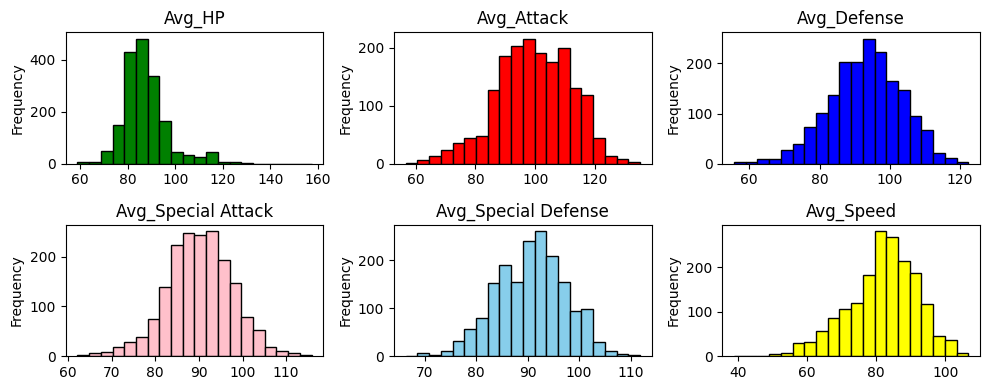

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Avg_HP'].dropna(),bins=20, color='green', edgecolor='black')
ax[0,0].set_title('Avg_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Avg_Attack'].dropna(),bins=20, color='red', edgecolor='black')
ax[0,1].set_title('Avg_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Avg_Defense'].dropna(),bins=20, color='blue', edgecolor='black')
ax[0,2].set_title('Avg_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Avg_Special Attack'].dropna(),bins=20, color='pink', edgecolor='black')
ax[1,0].set_title('Avg_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Avg_Special Defense'].dropna(),bins=20, color='skyblue', edgecolor='black')
ax[1,1].set_title('Avg_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Avg_Speed'].dropna(),bins=20, color='yellow', edgecolor='black')
ax[1,2].set_title('Avg_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

All the distributions for each Pokemon stat follow kind of a normal distribution, although a dip in the middle can be seen in the distribution of special defense.

Outliers are also prevalent in the dataset, especially in the average HP of a team. This can be better observed using a box plot shown below.

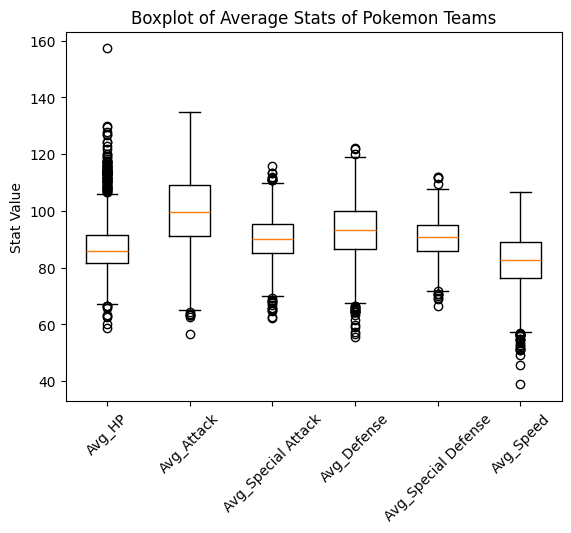

In [16]:
plots = ['Avg_HP', 'Avg_Attack', 'Avg_Special Attack', 'Avg_Defense', 'Avg_Special Defense', 'Avg_Speed']

plt.boxplot([showdown_df[plot].dropna() for plot in plots], tick_labels=plots)
plt.title("Boxplot of Average Stats of Pokemon Teams")
plt.xticks(rotation=45)
plt.ylabel("Stat Value")
plt.show()

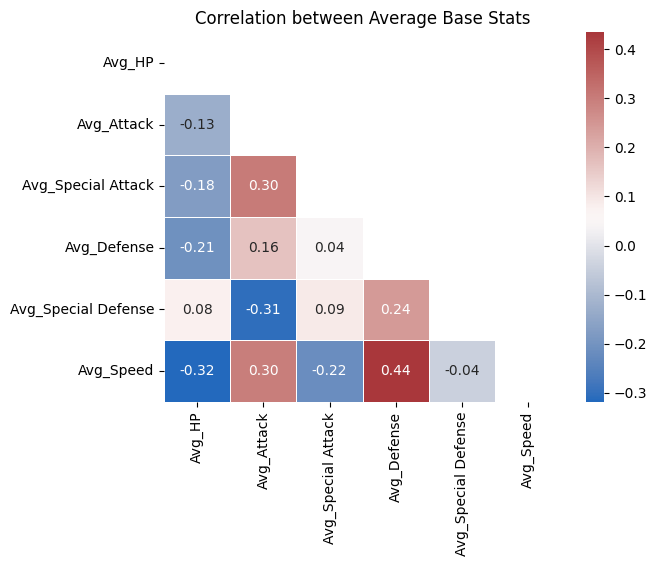

In [17]:
team_stats_df = showdown_df[
    [
        "Avg_HP",
        "Avg_Attack",
        "Avg_Special Attack",
        "Avg_Defense",
        "Avg_Special Defense",
        "Avg_Speed",
    ]
]
team_stats_correlation = team_stats_df.corr()
ax = sns.heatmap(
    team_stats_correlation,
    mask=np.triu(team_stats_correlation),
    annot=True,
    fmt = ".2f",
    linewidth=0.5,
    cmap="vlag"
)
plt.title("Correlation between Average Base Stats")
plt.show()

Looking at the box plot, the average HP of Pokemon teams has the most severe outlier. On the other hand, the average attack has the biggest interquartile range and whiskers, showing a wide distribution of attack values of each team.

### 4.2 Lead Pokemon

#### 4.2.1 Mode of Lead Pokemon

Another thing we would like to observe is which Pokemon is brought
out first. For this, we will use a bar graph and get the mode.

<Axes: xlabel='LeadPokemon'>

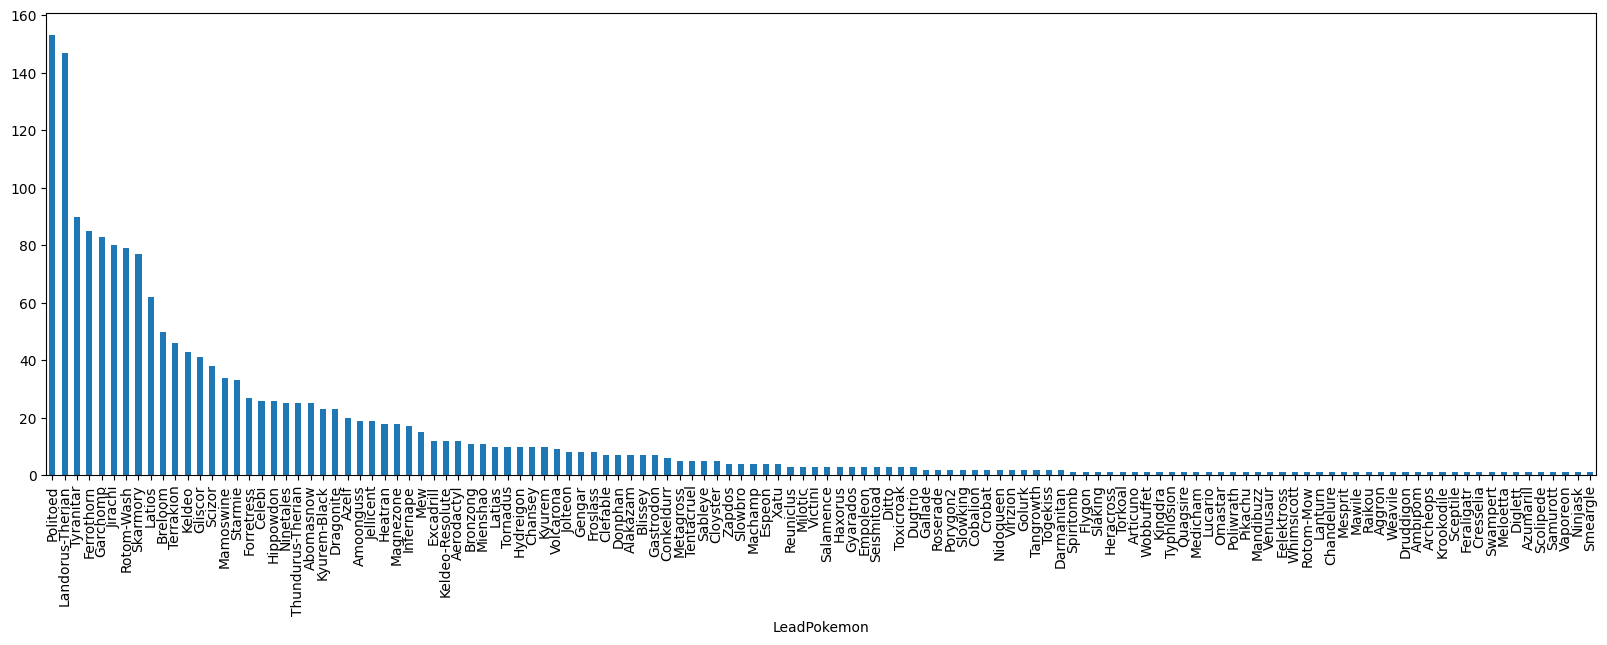

In [18]:
showdown_df["LeadPokemon"].value_counts()
showdown_df["LeadPokemon"].value_counts().plot(kind="bar", figsize=(20, 6))

In [19]:
showdown_df["LeadPokemon"].value_counts()

LeadPokemon
Politoed            153
Landorus-Therian    147
Tyranitar            90
Ferrothorn           85
Garchomp             83
                   ... 
Scolipede             1
Samurott              1
Vaporeon              1
Ninjask               1
Smeargle              1
Name: count, Length: 126, dtype: int64

As seen in the graph and the counts, most players choose to use Politoed
as their lead Pokemon, closely followed by Landorus-Therian, with the following
choices being at least 38.8% less frequently used.

#### 4.2.2 Lead Pokemon stat distribution

We also wanted to view the distribution of the stats
of each lead Pokemon in order to understand if the stats of a Pokemon
play a factor in why it is chosen as the lead.

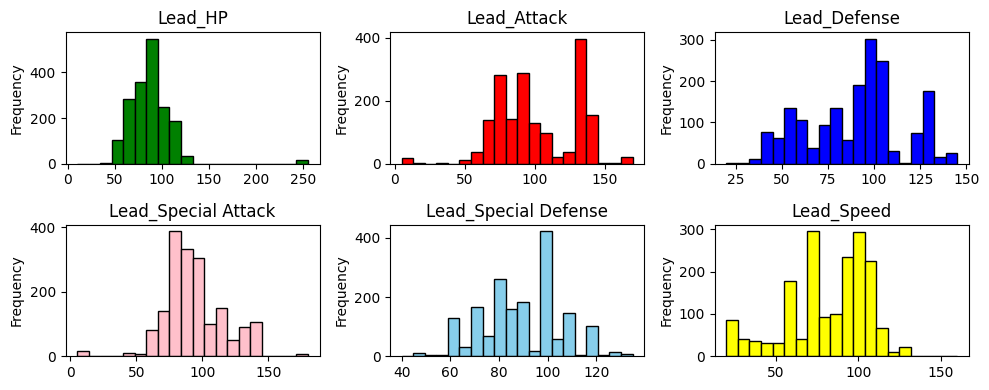

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

ax[0,0].hist(showdown_df['Lead_HP'],bins=20, color='green', edgecolor='black')
ax[0,0].set_title('Lead_HP')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(showdown_df['Lead_Attack'],bins=20, color='red', edgecolor='black')
ax[0,1].set_title('Lead_Attack')
ax[0,1].set_ylabel('Frequency')

ax[0,2].hist(showdown_df['Lead_Defense'],bins=20, color='blue', edgecolor='black')
ax[0,2].set_title('Lead_Defense')
ax[0,2].set_ylabel('Frequency')

ax[1,0].hist(showdown_df['Lead_Special Attack'],bins=20, color='pink', edgecolor='black')
ax[1,0].set_title('Lead_Special Attack')
ax[1,0].set_ylabel('Frequency')

ax[1,1].hist(showdown_df['Lead_Special Defense'],bins=20, color='skyblue', edgecolor='black')
ax[1,1].set_title('Lead_Special Defense')
ax[1,1].set_ylabel('Frequency')

ax[1,2].hist(showdown_df['Lead_Speed'],bins=20, color='yellow', edgecolor='black')
ax[1,2].set_title('Lead_Speed')
ax[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at the distribution of lead Pokemon stats, the values are more spread out. The HP stat is still the one with big outliers and we can view this better, including the different measures of dispersion.

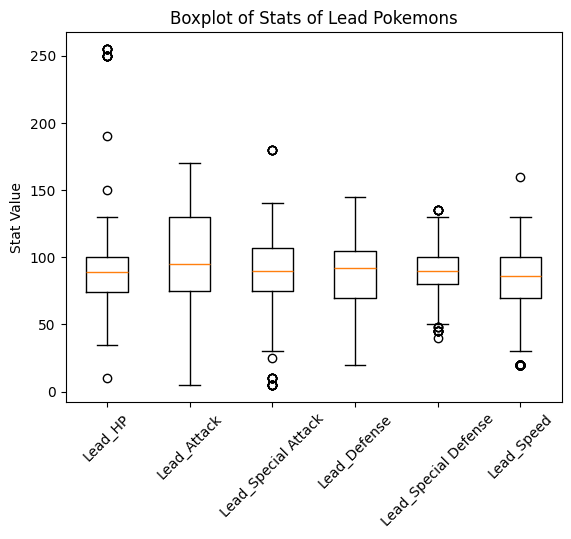

In [21]:
plots = ['Lead_HP', 'Lead_Attack', 'Lead_Special Attack', 'Lead_Defense', 'Lead_Special Defense', 'Lead_Speed']

plt.boxplot([showdown_df[plot].dropna() for plot in plots], tick_labels=plots)
plt.title("Boxplot of Stats of Lead Pokemons")
plt.xticks(rotation=45)
plt.ylabel("Stat Value")
plt.show()

As we can see, some Pokemon brought out as leads have an absurdly high amount of HP compared to the rest while Attack still has the biggest interquartile range.

### 4.3 Elo and Turncount

Another interesting set of statistics to explore is Elo and Turncount. Elo is
{{todo}}. TurnCount on the other hand simply measures

#### 4.3.1 Mean and Median of Elo and Turn Count

In [22]:
elo_turncount_df = showdown_df[['Elo', 'TurnCount']]

In [23]:
elo_turncount_df.agg(['mean', 'median'])

,Elo,TurnCount
mean,1383.954749,29.005587
median,1368.000000,24.000000


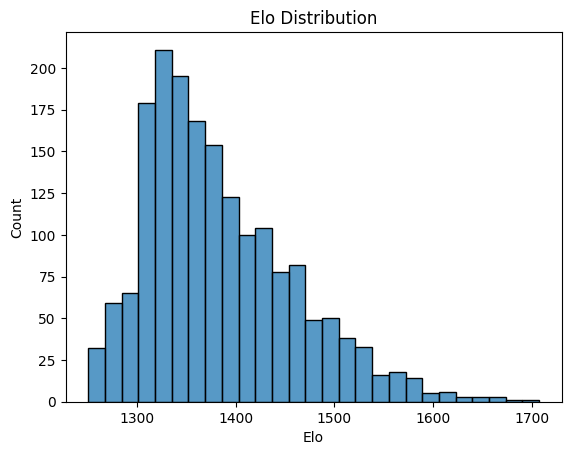

In [24]:
sns.histplot(elo_turncount_df['Elo'])
plt.title("Elo Distribution")
plt.show()

Based off the histogram, the elo distribution looks positively skewed.

But for a more quantifiable analysis, we conduct a Shapiro-Wilk test for normality.

* $H_0$: The data is normally distributed
* $H_a$: The data is not normally distributed

We set a significance level of $a = 0.05$.

In [25]:
statistic, p_value = sp.shapiro(elo_turncount_df['Elo'])

print(f"{p_value = }")

p_value = np.float64(6.169603471297848e-25)


With a p-value of around $4.06 \times 10^{-35} (< a = 0.05)$,
we reject $H_0$, i.e, elo is not normally distributed.

{{TODO: stuff about how this makes sense - Roymer said it's how elo really was
designed}}

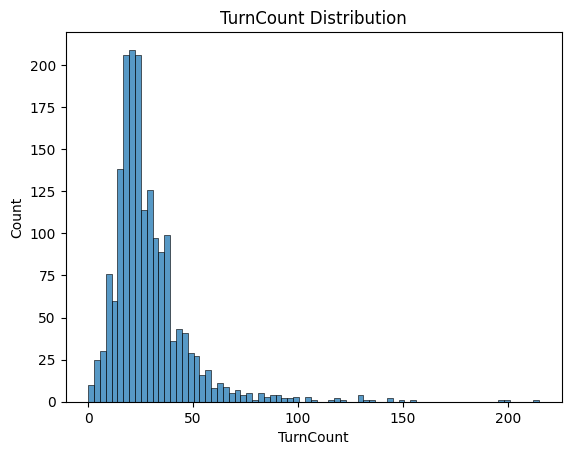

In [26]:
sns.histplot(elo_turncount_df['TurnCount'])
plt.title("TurnCount Distribution")
plt.show()

The turncount distribution appears positively skewed as well;
we again conduct a test for normality:

In [27]:
statistic, p_value = sp.shapiro(elo_turncount_df['TurnCount'])
print(f"{p_value = }")

p_value = np.float64(1.3193500384896357e-45)


With a p-value of around $1.55 \times 10^{-64} (< a = 0.05)$, we
reject $H_0$, i.e, turncount is not normally distributed.

{{TODO: mention stalling tech? I'm not sure if we should standardize here}}

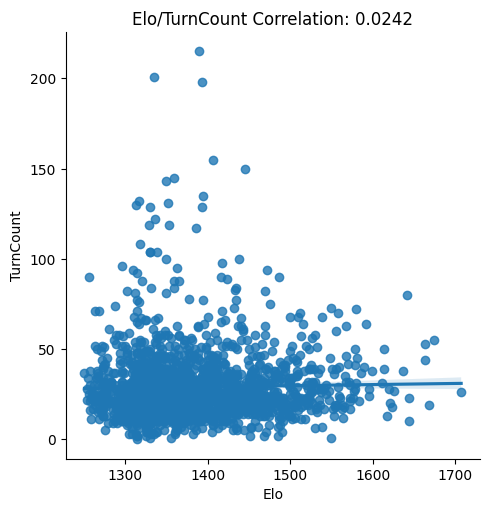

In [28]:
corr = elo_turncount_df.corr()['Elo']['TurnCount']
ax = sns.lmplot(x='Elo', y='TurnCount', data=elo_turncount_df)
plt.title(f"Elo/TurnCount Correlation: {corr:.4f}")
plt.show()

It would appear that there is very little correlation between elo and turncount.